In [1]:
!pip install -q --upgrade "s3fs>=2023.6.0"

In [1]:
import boto3

s3 = boto3.client('s3')
bucket = 'fireguarddata'
prefix = 'data/csv_files/historic_merged_firms_weather_and_era_data/california_only_data/'

# Filter only the `*_bigger_era5_firms_dataset.csv` files
response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
files = [obj['Key'] for obj in response.get('Contents', []) if obj['Key'].endswith('.csv')]

# Print to verify selected files
print("Selected files:")
for file in files:
    print(file)

print(f"Found {len(files)} CSV files.\n")

Selected files:
data/csv_files/historic_merged_firms_weather_and_era_data/california_only_data/2014_california_era5_firms_dataset.csv
data/csv_files/historic_merged_firms_weather_and_era_data/california_only_data/2015_california_era5_firms_dataset.csv
data/csv_files/historic_merged_firms_weather_and_era_data/california_only_data/2016_california_era5_firms_dataset.csv
data/csv_files/historic_merged_firms_weather_and_era_data/california_only_data/2017_california_era5_firms_dataset.csv
data/csv_files/historic_merged_firms_weather_and_era_data/california_only_data/2018_california_era5_firms_dataset.csv
data/csv_files/historic_merged_firms_weather_and_era_data/california_only_data/2019_california_era5_firms_dataset.csv
data/csv_files/historic_merged_firms_weather_and_era_data/california_only_data/2020_california_era5_firms_dataset.csv
data/csv_files/historic_merged_firms_weather_and_era_data/california_only_data/2021_california_era5_firms_dataset.csv
data/csv_files/historic_merged_firms_wea

Check Ram

In [11]:
import multiprocessing
import psutil

print("CPUs available:", multiprocessing.cpu_count())
print("RAM available (GB):", round(psutil.virtual_memory().total / 1e9, 2))


CPUs available: 48
RAM available (GB): 200.47


In [5]:
import psutil
ram = psutil.virtual_memory()
print(f"Used: {ram.used / 1e9:.2f} GB")
print(f"Available: {ram.available / 1e9:.2f} GB")
print(f"Total: {ram.total / 1e9:.2f} GB")


Used: 28.01 GB
Available: 170.75 GB
Total: 200.47 GB


In [6]:
!free -h


              total        used        free      shared  buff/cache   available
Mem:           186G         26G        157G        892K        2.9G        159G
Swap:            0B          0B          0B


In [23]:
import gc

# Clear unused variables
gc.collect()

17019

Check GPU

In [3]:
#check gpu
!nvidia-smi

Wed Mar 26 05:07:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10G                    On  |   00000000:00:1B.0 Off |                    0 |
|  0%   16C    P8              9W /  300W |       1MiB /  23028MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
import torch

print("GPU available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

GPU available: True
GPU name: NVIDIA A10G


## Data Cleaning and Preprocessing


In [10]:
# Inspect columns in each file
file_columns = {}

for i, file_key in enumerate(files):
    s3_path = f"s3://{bucket}/{file_key}"
    try:
        df_head = pd.read_csv(s3_path, storage_options={"anon": False}, nrows=5)
        file_columns[file_key] = df_head.columns.tolist()
    except Exception as e:
        file_columns[file_key] = f"Error reading file: {e}"

# Print out results
for file, columns in file_columns.items():
    print(f"\nFile: {file}")
    print("Columns:" if isinstance(columns, list) else "Issue:")
    print(columns)


File: data/csv_files/historic_merged_firms_weather_and_era_data/california_only_data/2014_california_era5_firms_dataset.csv
Columns:
['Unnamed: 0.1', 'Unnamed: 0', 'date', 'latitude', 'longitude', 'u10', 'v10', 'sp', 'lai_hv', 'lai_lv', 'tvl', 'skt_x', 'cl', 'swvl1', 'daynight', 'brightness', 'confidence', 'confidence_x', 'tvh', 'z', 'ie', 'skt_y', 'd2m', 't2m', 'tcc', 'tcrw', 'rsn', 'sd', 'tsn', 'stl1', 'slt']

File: data/csv_files/historic_merged_firms_weather_and_era_data/california_only_data/2015_california_era5_firms_dataset.csv
Columns:
['Unnamed: 0.1', 'Unnamed: 0', 'date', 'latitude', 'longitude', 'u10', 'v10', 'sp', 'lai_hv', 'lai_lv', 'tvl', 'skt_x', 'cl', 'swvl1', 'daynight', 'brightness', 'confidence', 'confidence_x', 'tvh', 'z', 'ie', 'skt_y', 'd2m', 't2m', 'tcc', 'tcrw', 'rsn', 'sd', 'tsn', 'stl1', 'slt']

File: data/csv_files/historic_merged_firms_weather_and_era_data/california_only_data/2016_california_era5_firms_dataset.csv
Columns:
['Unnamed: 0.1', 'Unnamed: 0', 'da

- Streams each CSV file from S3
- Handles inconsistent columns (e.g., skt_x, skt, etc.)
- Drops NA & duplicates per file
- Logs missing values and duplicates dropped

In [7]:
import boto3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import s3fs
import logging

# ========== SETUP ==========
bucket = "fireguarddata"
prefix = "data/csv_files/historic_merged_firms_weather_and_era_data/california_only_data/"
s3 = boto3.client("s3")
fs = s3fs.S3FileSystem(anon=False)

# List only .csv files in S3 path
response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
files = [obj['Key'] for obj in response.get('Contents', []) if obj['Key'].endswith(".csv")]

# Setup logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")

# Config
chunksize = 1_000_000
failed_files = []

# ========== FILE PROCESSOR FUNCTION ==========
def process_file(file_key):
    s3_path = f"s3://{bucket}/{file_key}"
    local_chunks = []

    total_na_dropped = 0
    total_dup_dropped = 0

    try:
        for chunk in pd.read_csv(s3_path, storage_options={"anon": False}, chunksize=chunksize, low_memory=False):
            # Drop all unnamed columns (e.g. "Unnamed: 0", "Unnamed: 0.1")
            unnamed_cols = [col for col in chunk.columns if col.startswith("Unnamed")]
            chunk.drop(columns=unnamed_cols, inplace=True, errors="ignore")

            # Drop additional columns if they exist
            drop_cols = ["number", "surface", "depthBelowLandLayer","step","valid_time"]
            chunk.drop(columns=drop_cols, inplace=True, errors="ignore")

            # Convert float64 to float32 to save memory
            float_cols = chunk.select_dtypes(include=["float64"]).columns
            chunk[float_cols] = chunk[float_cols].astype("float32")

            # Count & drop NA
            initial_len = len(chunk)
            chunk.dropna(inplace=True)
            na_dropped = initial_len - len(chunk)
            total_na_dropped += na_dropped

            # Drop duplicates
            len_after_na = len(chunk)
            chunk.drop_duplicates(inplace=True)
            dup_dropped = len_after_na - len(chunk)
            total_dup_dropped += dup_dropped

            # ---- Feature Engineering ---- #

            # Target
            if "brightness" in chunk.columns:
                if "daynight" in chunk.columns:
                    chunk["fire_occurrence"] = np.where(
                        chunk["daynight"] == "D",
                        (chunk["brightness"] > 325).astype(int),
                        (chunk["brightness"] > 320).astype(int)
                    )
                else:
                    raise ValueError("Missing 'daynight' column")
                chunk.drop(columns=["brightness"], inplace=True)
            else:
                raise ValueError("Missing 'brightness' column")

            # Date features
            if "date" in chunk.columns:
                chunk["date"] = pd.to_datetime(chunk["date"], errors="coerce")
                chunk["year"] = chunk["date"].dt.year
                chunk["month"] = chunk["date"].dt.month
                chunk["day"] = chunk["date"].dt.day
                chunk.drop(columns=["date"], inplace=True)
            else:
                raise ValueError("Missing 'date' column")

            # Surface temp (some files have skt_x/skt_y, others just skt)
            if "skt_x" in chunk.columns and "skt_y" in chunk.columns:
                chunk["skt"] = (chunk["skt_x"] + chunk["skt_y"]) / 2
                chunk.drop(columns=["skt_x", "skt_y"], inplace=True)
            elif "skt" in chunk.columns:
                chunk["skt"] = chunk["skt"]
            else:
                raise ValueError("Missing surface temperature columns")

            # Wind
            if "u10" in chunk.columns and "v10" in chunk.columns:
                chunk["wind_speed"] = np.sqrt(chunk["u10"]**2 + chunk["v10"]**2)
                chunk["wind_direction"] = np.degrees(np.arctan2(chunk["v10"], chunk["u10"]))
            else:
                raise ValueError("Missing wind components u10 or v10")

            # Fuel moisture and load
            chunk["fuel_load"] = chunk.get("lai_hv", 0) + chunk.get("lai_lv", 0)
            chunk["fuel_moisture"] = chunk.get("swvl1", 0)
            chunk["fuel_availability"] = chunk["fuel_load"] * (1 - chunk["fuel_moisture"])

            # Fire risk score
            chunk["fire_risk"] = (
                (chunk["skt"] * 0.4)
                + (chunk["wind_speed"] * 0.3)
                - (chunk["fuel_moisture"] * 0.2)
                + (chunk["fuel_availability"] * 0.1)
            )

            # Day/Night encoding
            if "daynight" in chunk.columns:
                chunk["daynight"] = chunk["daynight"].map({"D": 1, "N": 0})

            local_chunks.append(chunk)

        logging.info(f"{file_key}: Dropped {total_na_dropped} NAs and {total_dup_dropped} duplicates")
        return pd.concat(local_chunks, ignore_index=True)

    except Exception as e:
        failed_files.append((file_key, str(e)))
        print(f"Failed: {file_key} | {e}")
        return None

# ========== PARALLEL LOAD ==========
with ThreadPoolExecutor(max_workers=16) as executor:
    results = list(tqdm(executor.map(process_file, files), total=len(files)))

# Filter out failed files
processed_chunks = [r for r in results if r is not None]

if not processed_chunks:
    raise ValueError(" No valid data was processed from any files!")

df_full = pd.concat(processed_chunks, ignore_index=True)
print(f"\n Processed {len(processed_chunks)} files |  Failed {len(failed_files)} files")


2025-03-29 21:49:04,362 - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
2025-03-29 21:49:04,431 - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
2025-03-29 21:49:04,583 - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
2025-03-29 21:49:04,650 - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
2025-03-29 21:49:04,718 - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
2025-03-29 21:49:04,897 - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
2025-03-29 21:49:04,963 - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
2025-03-29 21:49:05,030 - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
2025-03-29 21:49:05,234 - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
2025-03-29 21:49:05,300 - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
2025-03-29 21:49:05,366 - Found credentials from I


 Processed 11 files |  Failed 0 files


saving full preprocessed file before splitting

In [9]:
from tqdm import tqdm
import s3fs

# Set up S3 path
s3_output_path = "s3://fireguarddata/data/preprocessed_data/df_full_preprocessed.csv"
fs = s3fs.S3FileSystem(anon=False)

# Define chunk size
chunk_size = 2_000_000

# Save in chunks with progress bar
with fs.open(s3_output_path, 'w') as f:
    # Write header only
    df_full.iloc[:0].to_csv(f, index=False)

    for start in tqdm(range(0, len(df_full), chunk_size), desc="Uploading to S3"):
        end = min(start + chunk_size, len(df_full))
        df_full.iloc[start:end].to_csv(f, index=False, header=False)


2025-03-29 21:54:10,474 - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
Uploading to S3: 100%|██████████| 41/41 [29:21<00:00, 42.97s/it]


Save all splits to new S3 prefix for downstream modeling

Splitting and Scaling

In [28]:
#function to this. not ran
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pandas as pd
import numpy as np

def split_and_scale(df_full, target_col="fire_occurrence", correlation_threshold=0.95, random_seed=42):
    """
    Preprocesses data by shuffling, splitting, dropping highly correlated features, and scaling.
    
    Parameters:
    - df_full (pd.DataFrame): Input DataFrame with features and target.
    - target_col (str): Name of the target column.
    - correlation_threshold (float): Threshold for dropping highly correlated features.
    - random_seed (int): Seed for reproducibility.
    
    Returns:
    - train_df, val_df, test_df (pd.DataFrame): Scaled and processed data splits.
    """

    print("\n Starting Data Splitting and Scaling...\n")

    # ========== SHUFFLING ==========
    print(" Shuffling data...")
    df_full = df_full.sample(frac=1, random_state=random_seed).reset_index(drop=True)

    # Separate features and target
    print(" Separating features and target...")
    X = df_full.drop(columns=[target_col])
    y = df_full[target_col]

    # ========== DROPPING NON-NUMERIC COLUMNS ==========
    print("Dropping non-numeric columns...")
    non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
    if non_numeric_cols:
        print(f"   Dropping non-numeric columns: {non_numeric_cols}")
        X.drop(columns=non_numeric_cols, inplace=True)

    # Ensure float32 for memory efficiency
    X = X.astype("float32")

    # ========== CORRELATION-BASED FEATURE DROPPING ==========
    print("\n Dropping highly correlated features...")
    # Compute correlation matrix
    corr_matrix = X.corr().abs()

    # Extract upper triangle to avoid duplication
    upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    upper_corr = pd.DataFrame(corr_matrix.values, columns=corr_matrix.columns, index=corr_matrix.index).where(upper)

    # Identify columns to drop based on correlation threshold
    to_drop = [col for col in upper_corr.columns if any(upper_corr[col] > correlation_threshold)]
    if to_drop:
        print(f"   Dropping {len(to_drop)} highly correlated columns: {to_drop}")
        X.drop(columns=to_drop, inplace=True)

    # Save feature names for consistent DataFrame creation
    feature_names = X.columns.tolist()

    # ========== SPLITTING DATA ==========
    print("\n Splitting into train, validation, and test sets...")
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=random_seed
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=random_seed
    )

    # ========== SCALING ==========
    print("\n Scaling features...")
    scaler = StandardScaler()
    with tqdm(total=3, desc="Scaling Data") as pbar:
        X_train_scaled = scaler.fit_transform(X_train)
        pbar.update(1)

        X_val_scaled = scaler.transform(X_val)
        pbar.update(1)

        X_test_scaled = scaler.transform(X_test)
        pbar.update(1)

    # ========== COMBINING BACK WITH TARGET ==========
    print("\n Combining scaled data with target...")
    train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
    train_df[target_col] = y_train.reset_index(drop=True)

    val_df = pd.DataFrame(X_val_scaled, columns=feature_names)
    val_df[target_col] = y_val.reset_index(drop=True)

    test_df = pd.DataFrame(X_test_scaled, columns=feature_names)
    test_df[target_col] = y_test.reset_index(drop=True)

    print("\n All splits processed, scaled, and ready for modeling.\n")
    return train_df, val_df, test_df

train_df, val_df, test_df = split_and_scale(df_full)

# Display the shape of the resulting splits
print(f"Training set shape: {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")
print(f"Test set shape: {test_df.shape}")



 Starting Data Splitting and Scaling...

 Shuffling data...
 Separating features and target...
Dropping non-numeric columns...
   Dropping non-numeric columns: ['confidence', 'confidence_x']

 Dropping highly correlated features...
   Dropping 4 highly correlated columns: ['z', 'stl1', 'fuel_moisture', 'fire_risk']

 Splitting into train, validation, and test sets...

 Scaling features...


Scaling Data: 100%|██████████| 3/3 [00:15<00:00,  5.09s/it]



 Combining scaled data with target...

 All splits processed, scaled, and ready for modeling.

Training set shape: (64434342, 30)
Validation set shape: (8054293, 30)
Test set shape: (8054293, 30)


Saving Train, Validation, and Test Data

In [30]:
from tqdm import tqdm
import s3fs

# Initialize S3
fs = s3fs.S3FileSystem(anon=False)
s3_base = "s3://fireguarddata/data/preprocessed_data"

# Save function with chunking
def save_dataframe_to_s3(df, s3_path, chunk_size=1_000_000):
    with fs.open(s3_path, 'w') as f:
        df.iloc[:0].to_csv(f, index=False)  # write header once
        for start in tqdm(range(0, len(df), chunk_size), desc=f"Saving {s3_path.split('/')[-1]}"):
            end = min(start + chunk_size, len(df))
            df.iloc[start:end].to_csv(f, index=False, header=False)

# File paths
train_path = f"{s3_base}/train.csv"
val_path = f"{s3_base}/val.csv"
test_path = f"{s3_base}/test.csv"

# Save with progress bars
save_dataframe_to_s3(train_df, train_path)
save_dataframe_to_s3(val_df, val_path)
save_dataframe_to_s3(test_df, test_path)

print("All splits saved to S3 with chunked writing.")


Saving test.csv: 100%|██████████| 9/9 [03:22<00:00, 22.48s/it]


All splits saved to S3 with chunked writing.


Investigate Columns

In [35]:
train_df.shape, val_df.shape, test_df.shape

((64434342, 30), (8054293, 30), (8054293, 30))

### EDA Plots 
#### Distribution of Fire Occurence

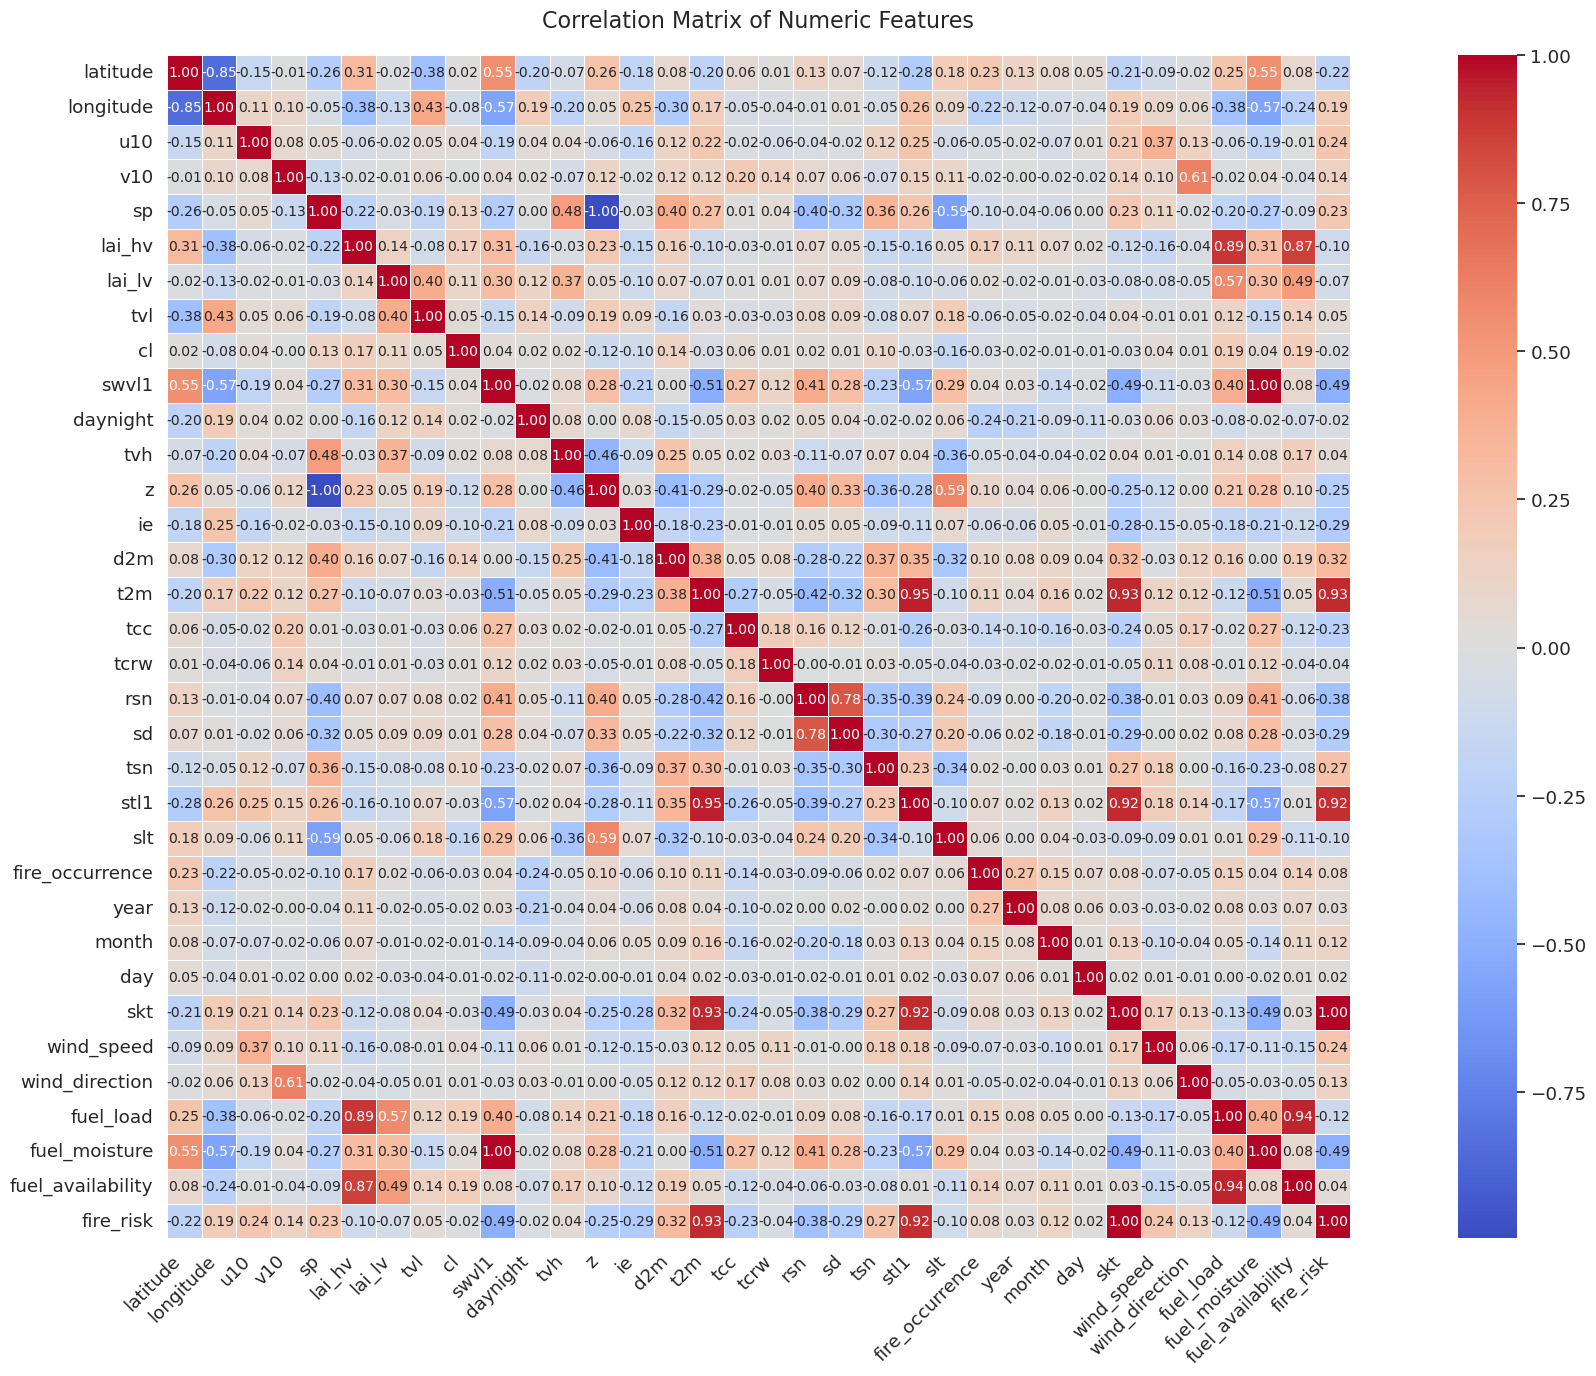

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_correlation_matrix(df, title="Correlation Matrix of Numeric Features"):
    """
    Plots the correlation matrix for numeric columns in the DataFrame.
    
    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - title (str): Title for the correlation matrix plot.
    """
    # Select numeric columns only
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    corr_matrix = df[numeric_cols].corr()

    # Plotting the correlation matrix
    plt.figure(figsize=(22, 14))
    sns.set(font_scale=1.2)

    heatmap = sns.heatmap(
        corr_matrix, 
        annot=True, 
        fmt=".2f", 
        cmap="coolwarm", 
        cbar=True, 
        square=True, 
        linewidths=0.5, 
        annot_kws={"size": 10},
    )

    plt.title(title, fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Usage
plot_correlation_matrix(df_full)

2025-03-29 21:35:26,017 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_32204/4013444698.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_full, x="fire_occurrence", palette="Reds")
2025-03-29 21:35:59,898 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


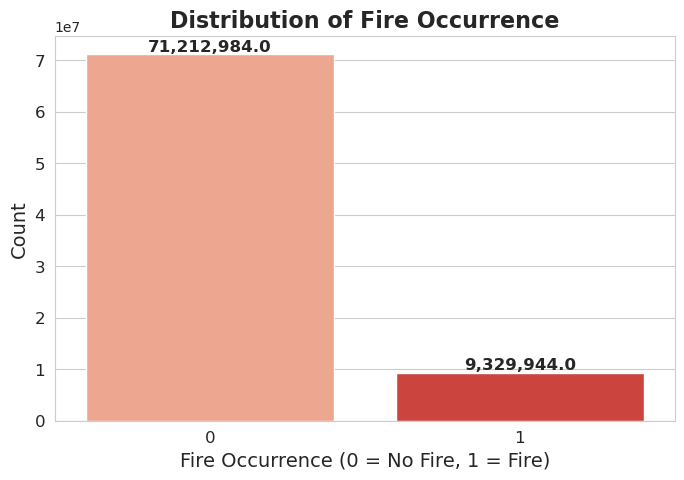

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set plot style
sns.set_style("whitegrid")

# Plot distribution
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df_full, x="fire_occurrence", palette="Reds")

# Add annotations
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Formatting
plt.title("Distribution of Fire Occurrence", fontsize=16, fontweight='bold')
plt.xlabel("Fire Occurrence (0 = No Fire, 1 = Fire)", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


#### Yearly Fire Occurrence Trend:
This plot shows how the number of fire occurrences changes year by year.

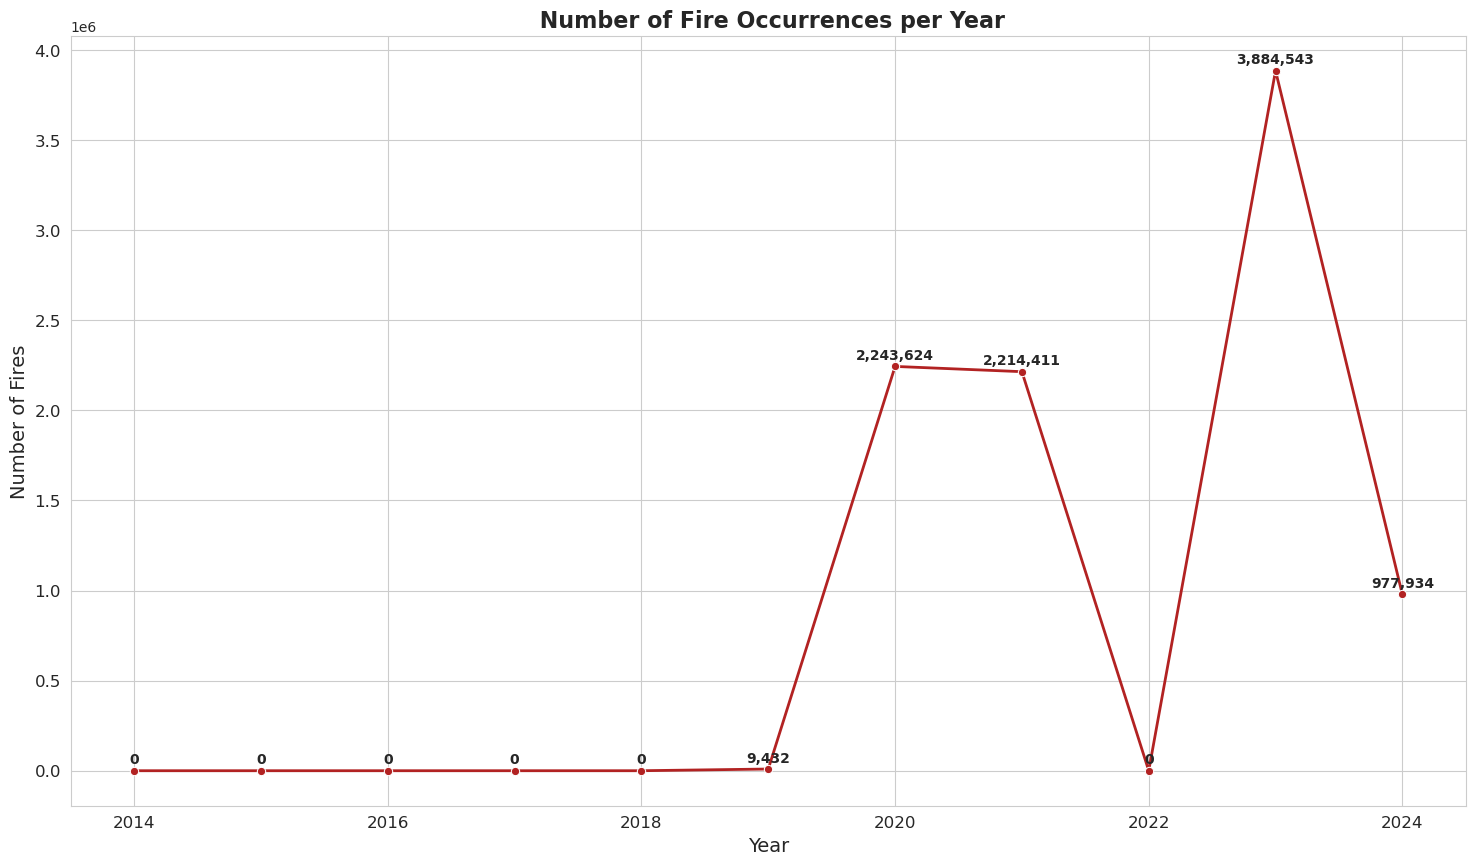

In [11]:
# Group by year and calculate fire counts
yearly_fires = df_full.groupby("year")["fire_occurrence"].sum().reset_index()

# Plot trend
plt.figure(figsize=(18, 10))
ax = sns.lineplot(data=yearly_fires, x="year", y="fire_occurrence", marker="o", color="firebrick", linewidth=2)

# Add annotations
for x, y in zip(yearly_fires["year"], yearly_fires["fire_occurrence"]):
    ax.annotate(f'{int(y):,}', 
                (x, y), 
                textcoords="offset points", 
                xytext=(0, 5), 
                ha='center', fontsize=10, fontweight='bold')

# Formatting
plt.title(" Number of Fire Occurrences per Year", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Fires", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


####  Fire Occurrence Proportion per Year:
Shows the proportion of fire occurrences each year.

2025-03-29 21:39:48,072 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_32204/308944181.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=yearly_proportion, x="year", y="fire_occurrence", palette="coolwarm")
2025-03-29 21:39:48,078 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


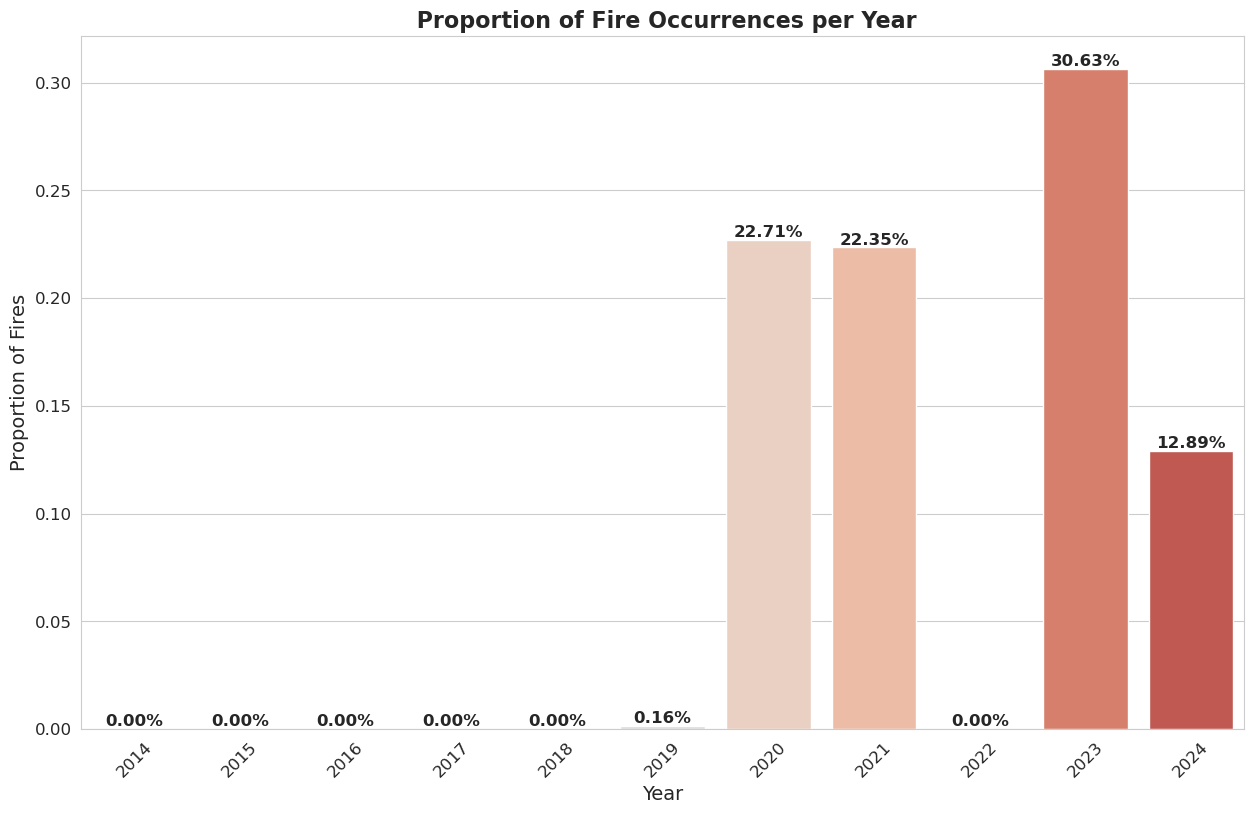

In [12]:
# Calculate proportion of fires per year
yearly_proportion = (
    df_full.groupby("year")["fire_occurrence"]
    .mean()
    .reset_index()
)

# Plot proportion trend
plt.figure(figsize=(15, 9))
ax = sns.barplot(data=yearly_proportion, x="year", y="fire_occurrence", palette="coolwarm")

# Add annotations
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2%}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Formatting
plt.title(" Proportion of Fire Occurrences per Year", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Proportion of Fires", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()


#### 4. Heatmap of Fires by Year and Month:
This heatmap shows the count of fire occurrences by year and month.

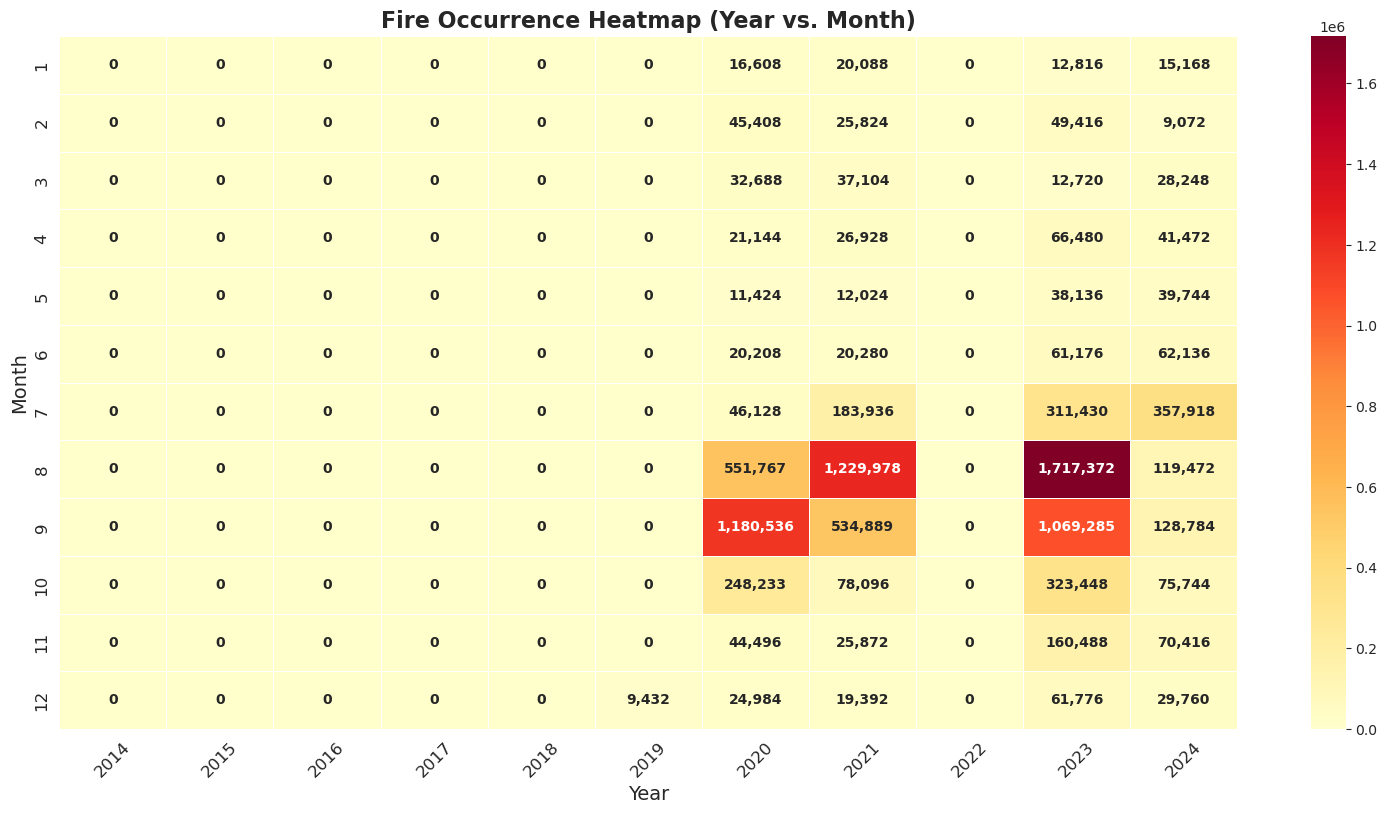

In [15]:
# Group by year and month for heatmap
heatmap_data = df_full.pivot_table(index="month", columns="year", values="fire_occurrence", aggfunc="sum", fill_value=0)

plt.figure(figsize=(19, 9))
ax = sns.heatmap(heatmap_data, annot=True, fmt=",d", cmap="YlOrRd", linewidths=0.5, annot_kws={"size": 10, "weight": "bold"})

# Formatting
plt.title("Fire Occurrence Heatmap (Year vs. Month)", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Month", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()


#### Fire Frequency by Month

2025-03-29 22:26:16,872 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_4482/1599023211.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_counts.index, y=monthly_counts.values, palette="flare")
2025-03-29 22:26:16,878 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


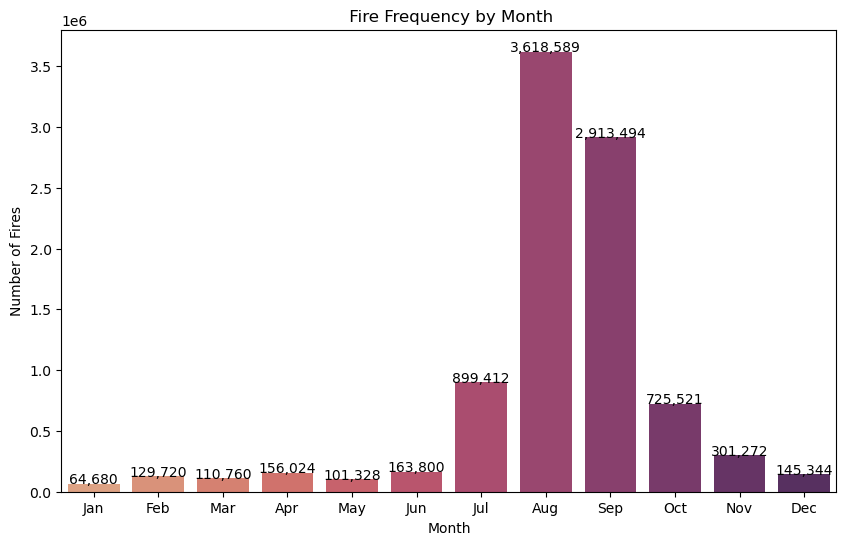

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by month and count fires
monthly_counts = df_full.groupby("month")["fire_occurrence"].sum()

plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_counts.index, y=monthly_counts.values, palette="flare")
plt.title(" Fire Frequency by Month")
plt.xlabel("Month")
plt.ylabel("Number of Fires")
plt.xticks(range(12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
for i, val in enumerate(monthly_counts.values):
    plt.text(i, val + 50, f"{val:,}", ha="center", fontsize=10)
plt.show()


In [ ]:
#### Average Fire Risk Score per Year

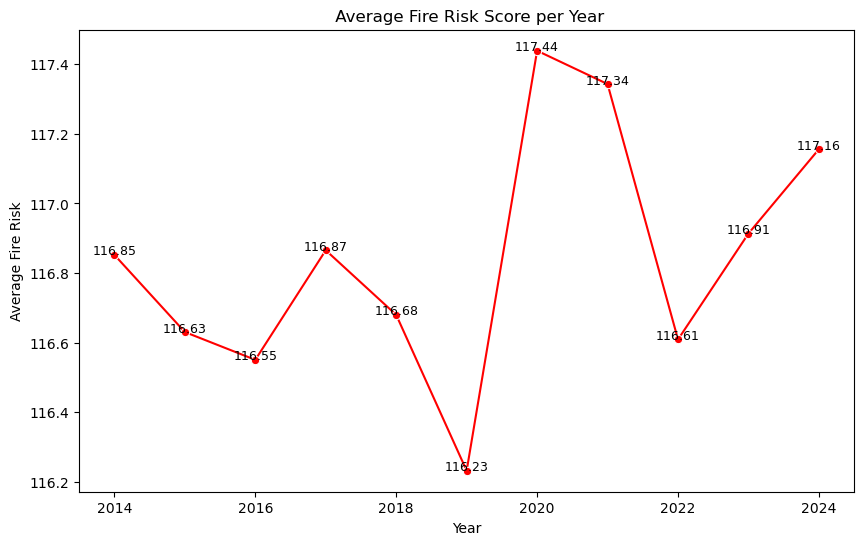

In [11]:
# Group by year and calculate average fire risk
avg_risk_per_year = df_full.groupby("year")["fire_risk"].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=avg_risk_per_year.index, y=avg_risk_per_year.values, marker="o", color="red")
plt.title(" Average Fire Risk Score per Year")
plt.xlabel("Year")
plt.ylabel("Average Fire Risk")
for i, val in enumerate(avg_risk_per_year.values):
    plt.text(avg_risk_per_year.index[i], val, f"{val:.2f}", ha="center", fontsize=9, color="black")
plt.show()


In [ ]:
#### Geographic Distribution of Fires

In [17]:
import geopandas as gpd
import folium

# Create a GeoDataFrame from latitude and longitude
gdf = gpd.GeoDataFrame(df_full, geometry=gpd.points_from_xy(df_full.longitude, df_full.latitude), crs="EPSG:4326")

# Create a folium map
m = folium.Map(location=[37.5, -119.5], zoom_start=6)

# Add fire occurrence points
for _, row in gdf.sample(1000).iterrows():  # Limit to 1000 points for performance
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=2,
        color="red" if row["fire_occurrence"] else "blue",
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

# Save map
m.save("fire_map.html")
m


KeyboardInterrupt: 

In [ ]:
#### Trend of Fire Risk Over Time

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


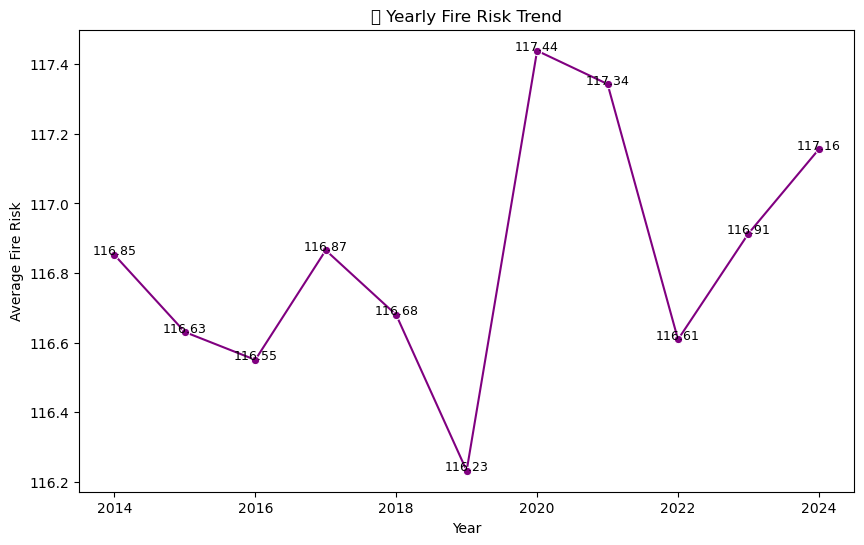

In [18]:
# Calculate yearly fire risk trend
yearly_risk = df_full.groupby("year")["fire_risk"].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=yearly_risk.index, y=yearly_risk.values, marker="o", color="purple")
plt.title("🔥 Yearly Fire Risk Trend")
plt.xlabel("Year")
plt.ylabel("Average Fire Risk")
for i, val in enumerate(yearly_risk.values):
    plt.text(yearly_risk.index[i], val, f"{val:.2f}", ha="center", fontsize=9, color="black")
plt.show()


In [ ]:
#### Fire Occurrence vs. Environmental Factors

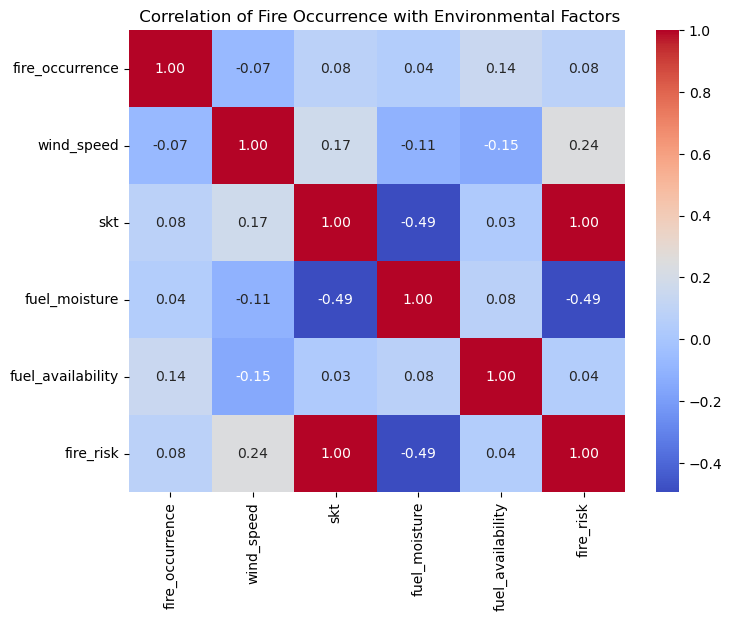

In [19]:
# Correlation matrix
corr = df_full[["fire_occurrence", "wind_speed", "skt", "fuel_moisture", "fuel_availability", "fire_risk"]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title(" Correlation of Fire Occurrence with Environmental Factors")
plt.show()


In [ ]:
#### Fire Occurrence by Day/Night

/tmp/ipykernel_4482/81013038.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Day", "Night"], y=daynight_counts.values, palette="dark:salmon")


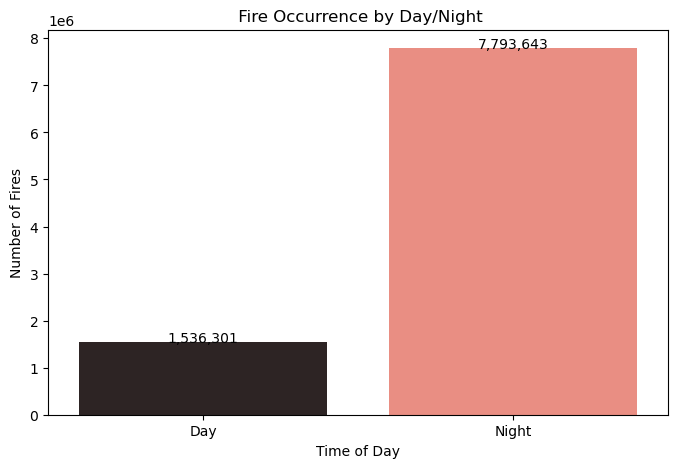

In [20]:
# Group by day/night and count fires
daynight_counts = df_full.groupby("daynight")["fire_occurrence"].sum()

plt.figure(figsize=(8, 5))
sns.barplot(x=["Day", "Night"], y=daynight_counts.values, palette="dark:salmon")
plt.title(" Fire Occurrence by Day/Night")
plt.xlabel("Time of Day")
plt.ylabel("Number of Fires")
for i, val in enumerate(daynight_counts.values):
    plt.text(i, val + 1000, f"{val:,}", ha="center", fontsize=10)
plt.show()


In [ ]:
#### Top 10 Most Affected Locations

In [21]:
# Group by latitude and longitude to find top fire locations
top_locations = df_full.groupby(["latitude", "longitude"])["fire_occurrence"].sum().nlargest(10)

plt.figure(figsize=(12, 7))
sns.barplot(y=top_locations.index.astype(str), x=top_locations.values, palette="Reds_r")
plt.title("Top 10 Most Affected Locations (Lat, Lon)")
plt.xlabel("Number of Fires")
plt.ylabel("Location (Latitude, Longitude)")
for i, val in enumerate(top_locations.values):
    plt.text(val + 50, i, f"{val:,}", va="center", fontsize=10)
plt.show()


TypeError: Setting a MultiIndex dtype to anything other than object is not supported

<Figure size 1200x700 with 0 Axes>

2025-03-29 22:32:19,010 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_4482/728180318.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=yearly_counts.index, y=pct_change.values, palette="Blues")
2025-03-29 22:32:19,016 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


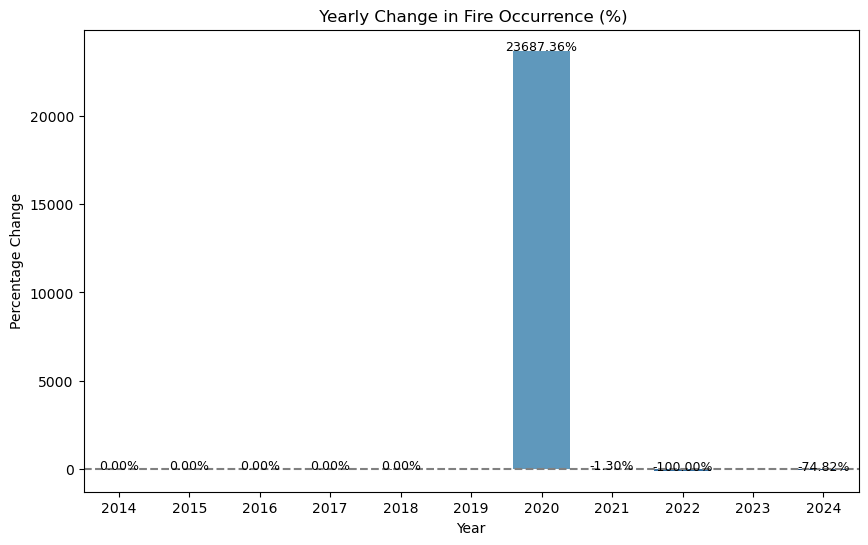

In [22]:
# Year-over-year percentage change
yearly_counts = df_full.groupby("year")["fire_occurrence"].sum()
pct_change = yearly_counts.pct_change().fillna(0) * 100

plt.figure(figsize=(10, 6))
sns.barplot(x=yearly_counts.index, y=pct_change.values, palette="Blues")
plt.title(" Yearly Change in Fire Occurrence (%)")
plt.xlabel("Year")
plt.ylabel("Percentage Change")
for i, val in enumerate(pct_change.values):
    plt.text(i, val + 2, f"{val:.2f}%", ha="center", fontsize=9)
plt.axhline(0, color="gray", linestyle="--")
plt.show()
